In [20]:
# from deepiforest.algorithms.dif import DIF

import sys
import os
sys.path.append(os.path.abspath("../../deep-i-forest/deep-iforest"))
from algorithms.dif import DIF

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [21]:
data = pd.read_csv('vacuum_sensor_data.csv', sep = ';')
data

,momento,1-0005,5-0005,1-_006,5-_006,1-_007,5-_007,1-_008,5-_008,1-_010,...,1-_098,5-_098,1-_099,5-_099,1-0112,5-0112,1-0116,5-0116,1-0109,5-0109
0,1,-588.88,-580.21,-590.50,-582.25,-593.51,-585.46,-595.51,-587.47,-575.36,...,-588.17,-581.42,-594.26,-586.26,-589.46,-581.75,-592.92,-586.26,-593.93,-586.30
1,2,-588.38,-579.71,-590.80,-582.46,-593.80,-585.67,-595.55,-587.59,-574.11,...,-588.34,-581.63,-594.51,-586.26,-589.29,-581.58,-592.80,-586.26,-594.13,-586.51
2,3,-584.41,-575.74,-585.83,-577.66,-591.38,-583.21,-589.84,-578.04,-563.34,...,-588.17,-581.33,-592.88,-584.34,-588.50,-580.62,-590.21,-583.75,-593.68,-585.84
3,4,-573.73,-565.27,-570.31,-562.81,-578.91,-571.24,-578.61,-565.90,-555.00,...,-584.79,-576.87,-580.62,-568.15,-586.96,-578.75,-578.66,-571.19,-590.88,-582.63
4,5,-567.27,-558.55,-562.26,-554.55,-570.69,-562.93,-567.18,-557.51,-545.99,...,-579.11,-570.99,-572.11,-560.43,-583.45,-574.91,-571.06,-563.56,-587.38,-578.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,637,-237.18,-253.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
637,638,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638,639,-237.14,-253.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
639,640,-237.10,-253.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#rename column to have consistent naming 
import re

def clean_column(col):
    if col == 'momento':
        return col
    match = re.match(r"(\d)-_?(\d+)", col)
    if match:
        sensor, comp = match.groups()
        return f"{sensor}-{int(comp):04d}"
    return col  # fallback in case format is already correct

# Apply renaming
data.columns = [clean_column(col) for col in data.columns]

In [23]:
# drop rows(seconds) where data from any sensor is missing
data=data.dropna(axis=0)

In [5]:
data.shape

(533, 77)

In [24]:
# narrow the time window
window = (data['momento'] >= 80) & (data['momento'] <= 150)





In [25]:
#split columns into train and validation
defective_columns = ['1-0116', '5-0116', '1-0109', '5-0109']
normal_control_columns = ['1-0008', '5-0008', '1-0064', '5-0064']
validation_columns = defective_columns + normal_control_columns

df_validation = data[['momento'] + validation_columns]
train_columns = [col for col in data.columns if col not in validation_columns]
df_train = data[train_columns]

df_train_windowed = df_train.loc[window]
df_validation_windowed = df_validation.loc[window]


In [9]:
#prepare and scale training data

import numpy as np
from sklearn.preprocessing import StandardScaler

# Drop 'momento' and select training sensor columns
X_train_raw = df_train_windowed.drop(columns=['momento'])

# Transpose so each row = one component's signal over time
X_train_transposed = X_train_raw.T.to_numpy()  # shape (n_components, n_timesteps_in_window)

# Function to scale each row (component) independently
def scale_rows(X):
    return np.array([StandardScaler().fit_transform(row.reshape(-1, 1)).flatten() for row in X])

X_train_scaled = scale_rows(X_train_transposed)



In [26]:
#prep validation data


X_val_raw = df_validation_windowed.drop(columns=['momento'])
X_val_transposed = X_val_raw.T.to_numpy()
X_val_scaled = scale_rows(X_val_transposed)



In [27]:
# train 2nd DIF model
import torch

dif = DIF(
    n_ensemble=100,
    n_hidden=[500, 100],   # Network structure
    n_emb=20,              # Embedding dimension
    activation='tanh',     # Activation function
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=1
)
dif.fit(X_train_scaled)




network additional parameters: {'n_hidden': [500, 100], 'n_emb': 20, 'skip_connection': None, 'dropout': None, 'activation': 'tanh', 'be_size': 100}
training done, time: 1.0


In [28]:
# Score validation data and predict anomalies

scores = dif.decision_function(X_val_scaled)
# Recreate preds with your threshold
threshold = np.percentile(scores, 90)
preds = (scores >= threshold).astype(int)




In [29]:
#define y_val - ground truth, components that are actually defective

# Get component names in same order as X_val (which is transposed)

component_names = df_validation.drop(columns=['momento']).columns.tolist()

# 1 for defective, 0 for normal
label_map = {col: 1 if col in defective_columns else 0 for col in component_names}
y_val = np.array([label_map[col] for col in component_names])


In [30]:
#visual de-bug
for i, name in enumerate(df_validation.drop(columns=['momento']).columns):
    print(f"Component: {name} | Score: {scores[i]:.3f} | Pred: {preds[i]} | True: {y_val[i]}")


Component: 1-0116 | Score: 0.318 | Pred: 0 | True: 1
Component: 5-0116 | Score: 0.364 | Pred: 0 | True: 1
Component: 1-0109 | Score: 0.291 | Pred: 0 | True: 1
Component: 5-0109 | Score: 0.346 | Pred: 0 | True: 1
Component: 1-0008 | Score: 0.394 | Pred: 1 | True: 0
Component: 5-0008 | Score: 0.317 | Pred: 0 | True: 0
Component: 1-0064 | Score: 0.290 | Pred: 0 | True: 0
Component: 5-0064 | Score: 0.344 | Pred: 0 | True: 0


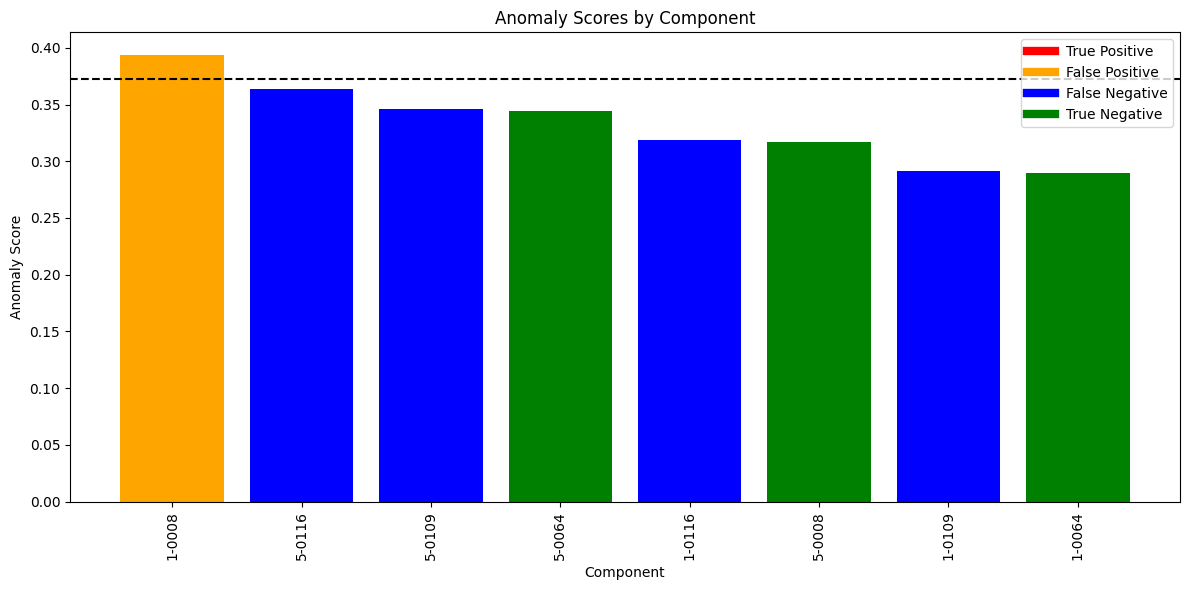

In [31]:
#visualize anomaly score

# Sort by score
sorted_idx = np.argsort(scores)[::-1]  # descending
sorted_scores = np.array(scores)[sorted_idx]
sorted_preds = preds[sorted_idx]
sorted_y_val = y_val[sorted_idx]
sorted_names = np.array(component_names)[sorted_idx]

# Assign colors
colors = []
for y, p in zip(sorted_y_val, sorted_preds):
    if y == 1 and p == 1:
        colors.append('red')    # True Positive
    elif y == 0 and p == 1:
        colors.append('orange') # False Positive
    elif y == 1 and p == 0:
        colors.append('blue')   # False Negative
    else:
        colors.append('green')  # True Negative

# Plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_names, sorted_scores, color=colors)
plt.axhline(y=threshold, color='black', linestyle='--', label='Anomaly Threshold')
plt.xticks(rotation=90)
plt.xlabel("Component")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Scores by Component")
plt.legend(handles=[
    plt.Line2D([0], [0], color='red', lw=6, label='True Positive'),
    plt.Line2D([0], [0], color='orange', lw=6, label='False Positive'),
    plt.Line2D([0], [0], color='blue', lw=6, label='False Negative'),
    plt.Line2D([0], [0], color='green', lw=6, label='True Negative'),
])
plt.tight_layout()
plt.show()



In [32]:
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_val, preds))

print("\nClassification Report:")
print(classification_report(y_val, preds, target_names=['Normal', 'Defective']))



Confusion Matrix:
[[3 1]
 [4 0]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.43      0.75      0.55         4
   Defective       0.00      0.00      0.00         4

    accuracy                           0.38         8
   macro avg       0.21      0.38      0.27         8
weighted avg       0.21      0.38      0.27         8



 Summary of Results

✅ Only 3 correct predictions (true negatives)
❌ No correct identification of defective components (0 recall for defectives)
❌ One normal component wrongly flagged as defective
This is worse than random guessing.